In [337]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.cluster import AffinityPropagation
from sklearn.covariance import GraphicalLassoCV
from sklearn.manifold import LocallyLinearEmbedding

from config import DATABASE_URI

plt.rcParams["figure.figsize"] = (15,10)

In [338]:
# All vanguard funds plus HYG, EMB, and IYR for junk bonds, emerging markets bonds, and real estate
# respectively.
# All created before the 2008 crash, IE before september 29 2008
tickers = ["EDV", "BIV", "BLV", "BSV", "BND", "VIG", "VUG", "VYM", "VV", "MGC", "MGK", "MGV", "VTI", "VTV",
           "VXF", "VO", "VOT", "VOE", "VB", "VBK", "VBR", "VT", "VEU", "VEA", "VGK", "VPL", "VWO",
           "HYG", "EMB", "IYR"]
tickers = tickers + []
with pg.connect(DATABASE_URI) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT date, ticker, closeadj FROM prices WHERE ticker IN {tuple(tickers)}")
        results = cur.fetchall()

In [339]:
df = pd.DataFrame.from_records(results, columns=["date", "ticker", "closeadj"], coerce_float=True)
# Set index, sort index, then transform into Series via squeeze
df = df.set_index(["date", "ticker"], verify_integrity=True).sort_index().squeeze()

In [340]:
returns = df.unstack().pct_change().dropna()

In [341]:
# Standardizing improves estimation of sparse covariance matrix
X = returns.values.copy()
X /= X.std(axis=0)

edge_model = GraphicalLassoCV().fit(X)

/home/eadains/EquitiesTrading/venv/lib/python3.8/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


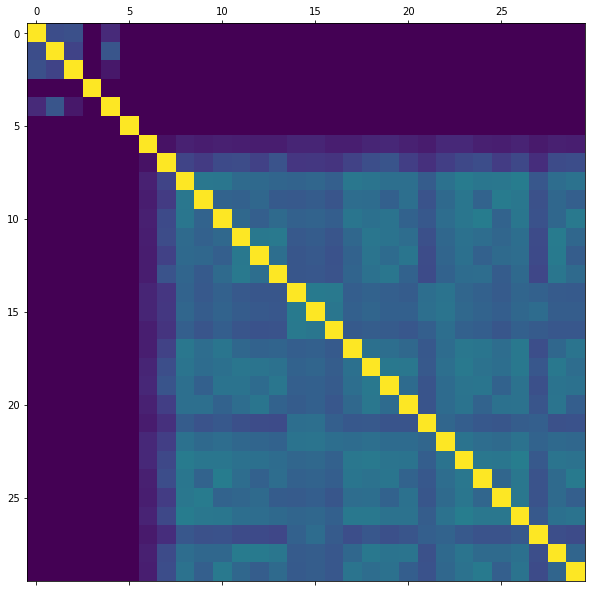

In [342]:
plt.matshow(edge_model.covariance_)

In [347]:
clustering = AffinityPropagation(affinity="precomputed", max_iter=1000).fit(edge_model.covariance_)

/home/eadains/EquitiesTrading/venv/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [348]:
embed = LocallyLinearEmbedding(n_neighbors=10, n_components=2)
embed = embed.fit_transform(edge_model.covariance_)

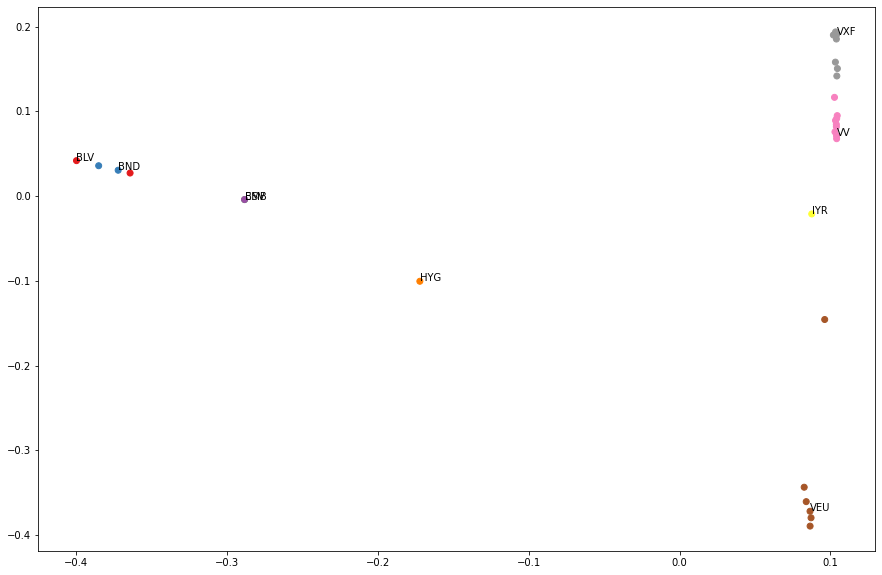

In [349]:
plt.scatter(embed[:, 0], embed[:, 1], c=clustering.labels_, cmap="Set1")

labels = returns.columns[clustering.cluster_centers_indices_]
points = embed[clustering.cluster_centers_indices_]
for i, label in enumerate(labels):
    plt.annotate(label, (points[i, 0], points[i, 1]))

In [350]:
n_labels = clustering.labels_.max()

for i in range(n_labels + 1):
    print(f"Cluster {i+1}: {', '.join(returns.columns[clustering.labels_ == i])}")

Cluster 1: BLV, EDV
Cluster 2: BIV, BND
Cluster 3: BSV
Cluster 4: EMB
Cluster 5: HYG
Cluster 6: IYR
Cluster 7: VEA, VEU, VGK, VPL, VT, VWO
Cluster 8: MGC, MGK, MGV, VIG, VTI, VTV, VUG, VV, VYM
Cluster 9: VB, VBK, VBR, VO, VOE, VOT, VXF
